In [1]:
import sys, os
import pathlib
import time
import importlib
import joblib
import pickle
from scipy.sparse import csr_matrix

import numpy as np
from scipy.linalg import null_space


import matplotlib.pyplot as plt

import cv2

In [2]:
sys.path

['C:\\home\\study\\git_test\\curve_sketch\\real_data',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv\\python37.zip',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv\\DLLs',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv\\lib',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv',
 '',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv\\lib\\site-packages',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv\\lib\\site-packages\\locket-0.2.1-py3.7.egg',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv\\lib\\site-packages\\win32',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\murata\\anaconda3\\envs\\py37cv\\lib\\site-packages\\IPython\\extensions',
 'C:\\home\\.ipython']

In [3]:
%load_ext autoreload
%autoreload 2

if not os.path.abspath("../") in sys.path:
    sys.path.append(os.path.abspath("../"))
    sys.path.append(os.path.abspath("../src"))

from src import normalization
from src import Camera, metashape_Camera
from src import camera_correspondence, FF_mat, epipole_angle, pair_and_key_gen, coll_dict_gen, pair_pt_gen
from src import FR_check, coordinate_dict_gen
from src import min_dist, tri, TDlines_gen, reprojection_gen, gen_support_dict, gen_support
from src import all_D, frag_list_fraged, all_sep

## パイプライン

In [4]:
cam_list = [metashape_Camera(i) for i in range(0,264)]
for i in range(len(cam_list)):
    cam_list[i].img_load()
    cam_list[i].contour_load()
    cam_list[i].label_load()
    cam_list[i].correspondence_contour()
    cam_list[i].para_load()
    

C:\home\study\git_test\curve_sketch\src\camera.py:89: UserWarning: loadtxt: Empty input file: "masks\GmJMC025_02_mask\245_3.csv"
  idx = np.loadtxt(str(csv_path), delimiter=",")


In [5]:
kernel = np.ones((3,3),np.uint8)

for cnum in range(len(cam_list)):
    sparse_mats_list = []
    for j in range(len(cam_list[cnum].contour_list)):
        new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.uint8)
        for i in range(len(cam_list[cnum].contour_list[j])):
            curve = cam_list[cnum].contour_list[j][i][~np.isnan(cam_list[cnum].contour_list[j][i])].reshape((-1,2)).astype(int)
            new_img[curve[:,1],curve[:,0]]=True
        dilation = cv2.dilate(new_img, kernel, iterations = 20)
        new_img = csr_matrix(dilation, dtype=np.uint8)
        sparse_mats_list.append(new_img)
        
    cam_list[cnum].contour_img = sparse_mats_list

In [6]:
cam_list[cnum].contour_img

[<3456x5184 sparse matrix of type '<class 'numpy.uint8'>'
 	with 0 stored elements in Compressed Sparse Row format>,
 <3456x5184 sparse matrix of type '<class 'numpy.uint8'>'
 	with 11397 stored elements in Compressed Sparse Row format>,
 <3456x5184 sparse matrix of type '<class 'numpy.uint8'>'
 	with 0 stored elements in Compressed Sparse Row format>,
 <3456x5184 sparse matrix of type '<class 'numpy.uint8'>'
 	with 61756 stored elements in Compressed Sparse Row format>,
 <3456x5184 sparse matrix of type '<class 'numpy.uint8'>'
 	with 91860 stored elements in Compressed Sparse Row format>]

In [7]:
# エピポール取得
cam_pairs = camera_correspondence(cam_list)

epipole_dict = {i:[] for i in range(len(cam_list))}
cam_pairs_F = {}
for i in cam_pairs:
    epipole1, epipole2, F = FF_mat(cam_list[i[0]].A, cam_list[i[1]].A, cam_list[i[0]].Rt, cam_list[i[1]].Rt)
    epipole_dict[i[0]].append(normalization(epipole1))
    epipole_dict[i[1]].append(normalization(epipole2))
    cam_pairs_F[i] = F

In [8]:
print(len(cam_pairs))

1334


In [9]:
# フラグメントのリストを作る
for i in range(len(cam_list)):
    im_del_list = all_D(epipole_angle(i, epipole_dict, cam_list=cam_list))# im_del_list[color][contour][del_idx]
    newCon = all_sep(cam_list[i].contour_list, im_del_list)# newCon[color][fragment][coordination]
    cam_list[i].frag_list = frag_list_fraged(newCon)
    
del epipole_dict

C:\home\study\git_test\curve_sketch\src\epipolar.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return list(map(lambda y: (y - min(B)) / (max(B) - min(B)), B))


cnum = 3
new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)

for j in range(len(cam_list[cnum].frag_list)):
    for i in range(len(cam_list[cnum].frag_list[j])):
        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
        new_img[curve[:,1],curve[:,0]]=True

%matplotlib inline
fig = plt.figure(figsize = (20, 20))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111)
plt.imshow(new_img)

## ペア生成

In [10]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(pair_and_key_gen)(
    i, cam_list=cam_list, cam_pairs_F=cam_pairs_F) for i in cam_pairs_F)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 12.2min
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 17.1min
[Parallel(

In [11]:
temp_path = pathlib.Path("temp/")
tags_path = list(temp_path.glob("*.pair_list"))

tags = []
for tag_path in tags_path:
    tag_sp = tag_path.stem.split("_")
    tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
    tags.append(tag_arr)

In [12]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(coll_dict_gen)(i, cam_list, cam_pairs_F) for i in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 3

In [13]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(pair_pt_gen)(i) for i in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [14]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(coordinate_dict_gen)(i, cam_list=cam_list) for i in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 2

## 三次元再構築

In [15]:
_ = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(TDlines_gen)(
    tag, cam_list=cam_list, cam_pairs_F=cam_pairs_F) for tag in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 4

In [16]:
%%time
import joblib
_ = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(reprojection_gen)(tag, cam_list=cam_list) for tag in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 3

Wall time: 3h 49min 44s


In [19]:
%%time
import joblib
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(gen_support)(tag, cam_list=cam_list) for tag in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 67.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 83.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 91.8min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 113.1min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 132.5min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 151.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 175.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 194.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 215.4min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elap

Wall time: 1d 2h 37min 2s


In [35]:
sup_th = 90# サポート数
curve_fragment = []
for tag in tags:
    if tag[1] == "R":
        continue
    
    with open(r"temp/{0}_{1}_{2}.TDlines".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        lines_list = pickle.load(f)
    #lines_list = TDlines[tag]
        
    with open(r"temp/{0}_{1}_{2}.support_dict".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        support_list, support_ac = pickle.load(f)
    #support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
    tag_list = []
    for col, sup_col, ac_col in zip(lines_list, support_list, support_ac):
        col_curve_fragment = []
        for frag, sup, sup_ac in zip(col, sup_col, ac_col):
            if sup > sup_th:
                frag = np.reshape(frag,(-1, 3))
                frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
                col_curve_fragment.append(frag)
        tag_list.append(col_curve_fragment)
    curve_fragment.append(tag_list)

In [36]:
cfs = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
for cols in curve_fragment:
    for i in range(len(cols)):
        if i == 0:
            cfs[0] += cols[i]
        if i == 1:
            cfs[1] += cols[i]
        if i == 2:
            cfs[2] += cols[i]
        if i == 3:
            cfs[3] += cols[i]
        if i == 4:
            cfs[4] += cols[i]
        if i == 5:
            cfs[5] += cols[i]
        if i == 6:
            cfs[6] += cols[i]
        if i == 7:
            cfs[7] += cols[i]
        if i == 8:
            cfs[8] += cols[i]
        if i == 9:
            cfs[9] += cols[i]
        if i == 10:
            cfs[10] += cols[i]
        if i == 11:
            cfs[11] += cols[i]
        if i == 12:
            cfs[12] += cols[i]

<IPython.core.display.Javascript object>


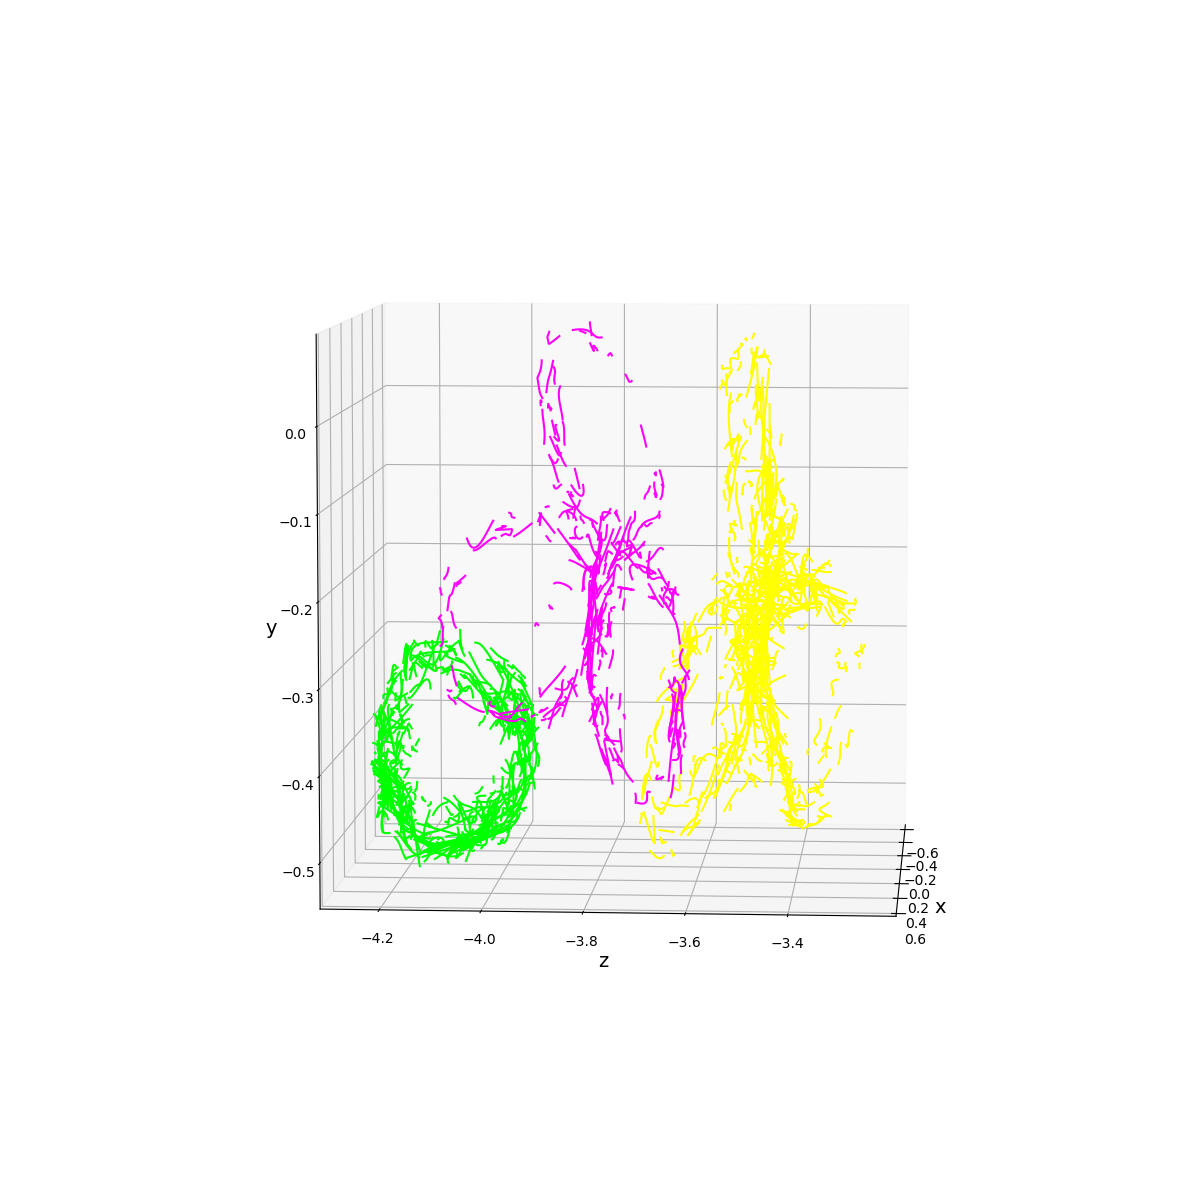

In [37]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if frag.size == 0:
                continue
            #print(frag)
            
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            if j % 100 == 0:
                ax.plot(new[0], new[2], new[1],"-",color=c)
            
            j+=1
            
        
%matplotlib notebook
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))
#ax.set_xticks(np.arange(-4,4,1))
#ax.set_yticks(np.arange(-4,4,1))
#ax.set_zticks(np.arange(-2,9,1))

plot_graph()

In [38]:
import itertools

import open3d as o3d

flatten_curve_frag = np.array(list(itertools.chain.from_iterable(_curve_fragment)))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)

o3d.visualization.draw_geometries([pcd])

from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

def plot_graph():
    i = 0
    for c_f in curve_fragment:
        for frag in c_f:
            if frag.size == 0:
                continue
            #print(frag)
            
            if i%100 == 0:
                x = frag[:,0]
                y = frag[:,1]
                z = frag[:,2]
                data = [x,y,z]
                try:
                    tck, u= interpolate.splprep(data, k=3)
                except ValueError:
                    pass
                except TypeError:
                    pass
                new = interpolate.splev(u, tck, der=0)

                ax.plot(new[0], new[2], new[1],"-")
                    #ax.plot(x, z, y,"-")
            i += 1

def plt_graph3d(angle):
    ax.view_init(azim=angle*5)
    
# アニメーションを作成
ani = FuncAnimation(
    fig,
    func=plt_graph3d,
    frames=72,
    init_func=plot_graph,
    interval=200
)

# imagemagickで作成したアニメーションをGIFで書き出す
ani.save("48_rolling.gif", writer="pillow", savefig_kwargs={'transparent': True, 'facecolor': 'none'})
#ani.save('48_anim.mp4', writer="ffmpeg", savefig_kwargs={'transparent': True, 'facecolor': 'none'})

In [39]:
import pickle
with open("old_ply_comp_2.curves","wb") as f:
    pickle.dump(curve_fragment, f)